# **Data Visualisation**

## Objectives

* Visualise the difference between healthy and leaves affected by powdery mildew.

## Inputs
* inputs/cherry-leaves/train
* inputs/cherry-leaves/test
* inputs/cherry-leaves/validation

## Outputs

* Save image shape file
* Save mean and variability of images
* Difference between healthy and leaves affected by powdery mildew

## Additional Comments

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/P5-Mildew-Detection/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/P5-Mildew-Detection'

### Directories

In [4]:
base_dir = "/workspace/P5-Mildew-Detection"
test_dir = "inputs/test"
train_dir = "inputs/cherry-leaves/train"
validation_dir = "inputs/validation"
cherry_leaves_dir = 'inputs/cherry-leaves'


### Output Directory

In [5]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(base_dir) and version in os.listdir(base_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set Labels

In [6]:
labels = os.listdir(train_dir)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


### Average Image Size

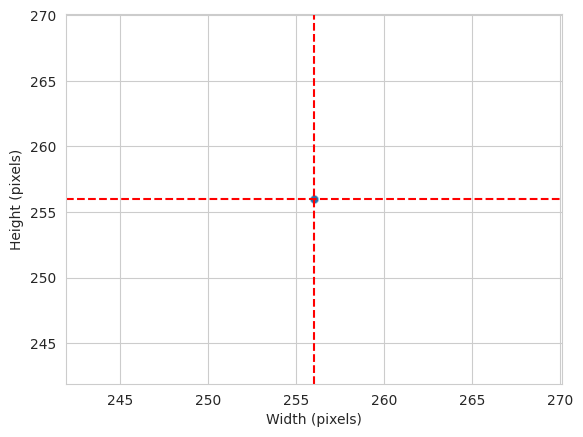

Width average: 256 
Height average: 256


In [7]:
from matplotlib.image import imread
import seaborn as sns
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np

dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_dir + '/' + label):
        img = imread(train_dir + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)
        dim2.append(d2)

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

### Image Shape

In [8]:
image_shape = (100,100,3)

### Save Image Shape

In [9]:
import joblib
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

### Average and Variability of Images

In [10]:
from tensorflow.keras.preprocessing import image
import numpy as np

def show_images(cherry_leaves_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(cherry_leaves_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(cherry_leaves_dir + '/' + label):
            if counter < n_images_per_label:

                img = image.load_img(
                    cherry_leaves_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y


In [11]:
X, y = show_images(cherry_leaves_dir=train_dir,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 100, 100, 3) (60,)


### Save The Mean And Variability Of Images

In [12]:
import seaborn as sns
import streamlit as st
import matplotlib.pyplot as plt

def image_analysis(X, y, figsize=(12,5), save_image=False):
    

    sns.set_style("white")
    for label_to_display in np.unique(y):
        y = y.reshape(-1,1,1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg = np.mean(arr, axis=0)
        variability = np.std(arr, axis=0)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average Image for label {label_to_display}")
        axes[0].imshow(avg, cmap='gray')
        axes[1].set_title(f"Image Variability for label {label_to_display}")
        axes[1].imshow(variability, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")



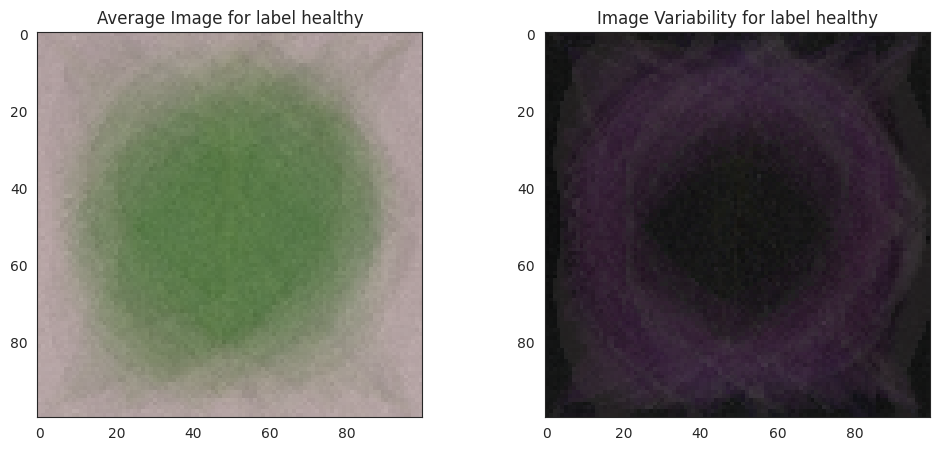

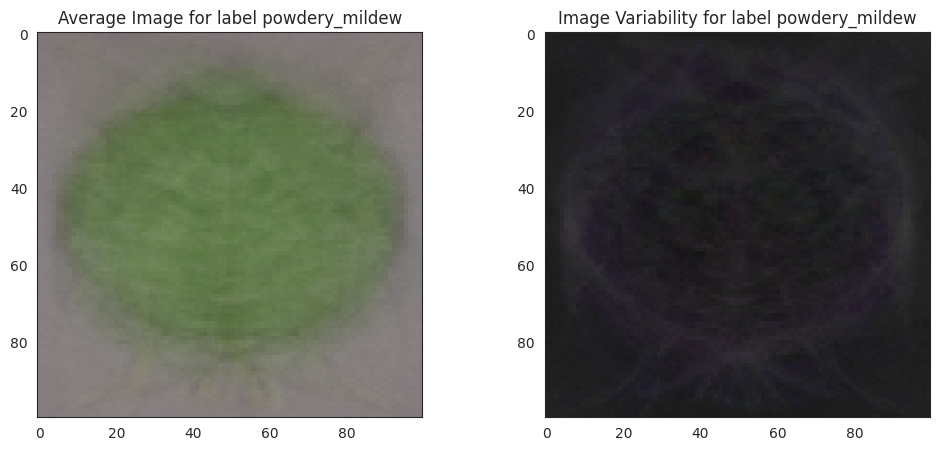

In [13]:
image_analysis(X=X, y=y, figsize=(12, 5), save_image=True)

### Difference Of Average Healthy and Powdered Mildew Images

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def subset_image(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = (y == label_to_display).reshape(-1)
    df = X[boolean_mask]
    return df

def contrast_between_labels(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either label {label_1} or label {label_2} are not in {np.unique(y)}")
        return

    img_lbl_one = subset_image(X, y, label_1)
    healthy_avg = np.mean(img_lbl_one, axis=0)

    img_lbl_two = subset_image(X, y, label_2)    
    mildew_avg = np.mean(img_lbl_two, axis=0)

    contrast_mean = healthy_avg - mildew_avg
    contrast_mean_normalized = (contrast_mean - np.min(contrast_mean)) / (np.max(contrast_mean) - np.min(contrast_mean))

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(healthy_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(mildew_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(contrast_mean_normalized, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

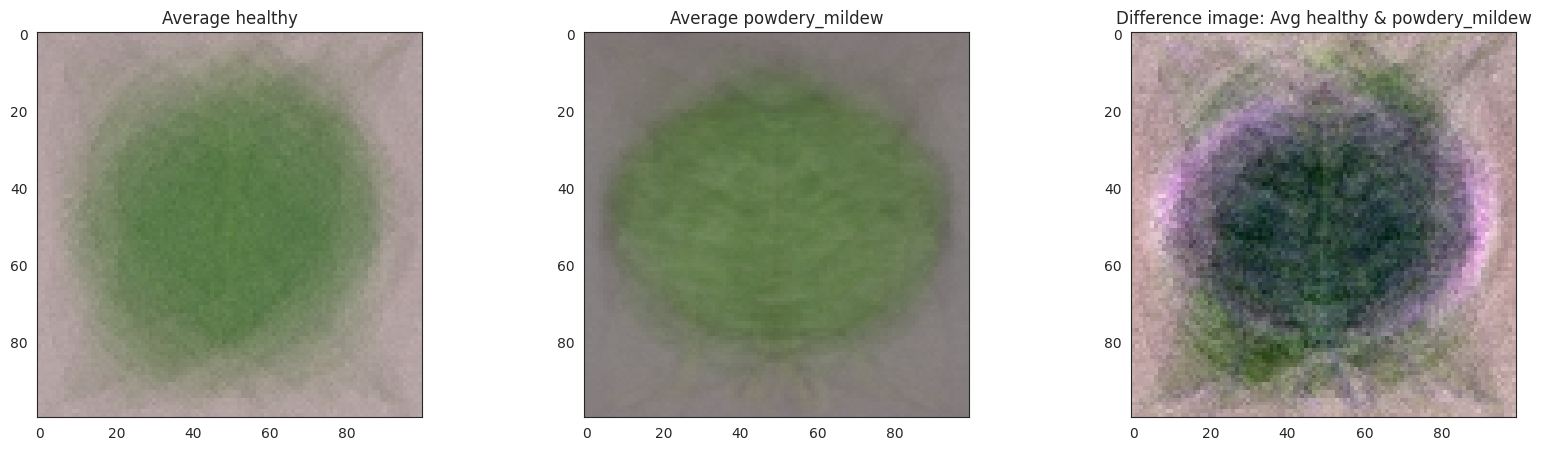

In [15]:
contrast_between_labels(X=X, y=y, label_1='healthy', label_2='powdery_mildew', save_image=True)

### Image Montage

In [16]:
import itertools
import random

sns.set_style("white")

def image_montage(image_shape, dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):

    labels = os.listdir(dir_path)

    if label_to_display in labels:
        image_set = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(image_set):
            img_idx = random.sample(image_set, nrows * ncols)
        else:
            print(
                f"Lower the amount of nrows and ncols to create montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You asked for a montage with {nrows * ncols} spaces")
            return

        amount_of_rows = range(0, nrows)
        amount_of_cols = range(0, ncols)
        plot_idx = list(itertools.product(amount_of_rows, amount_of_cols))

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = image_shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("This label does not exist. Please try again.")
        print(f"The other options are: {labels}")

healthy


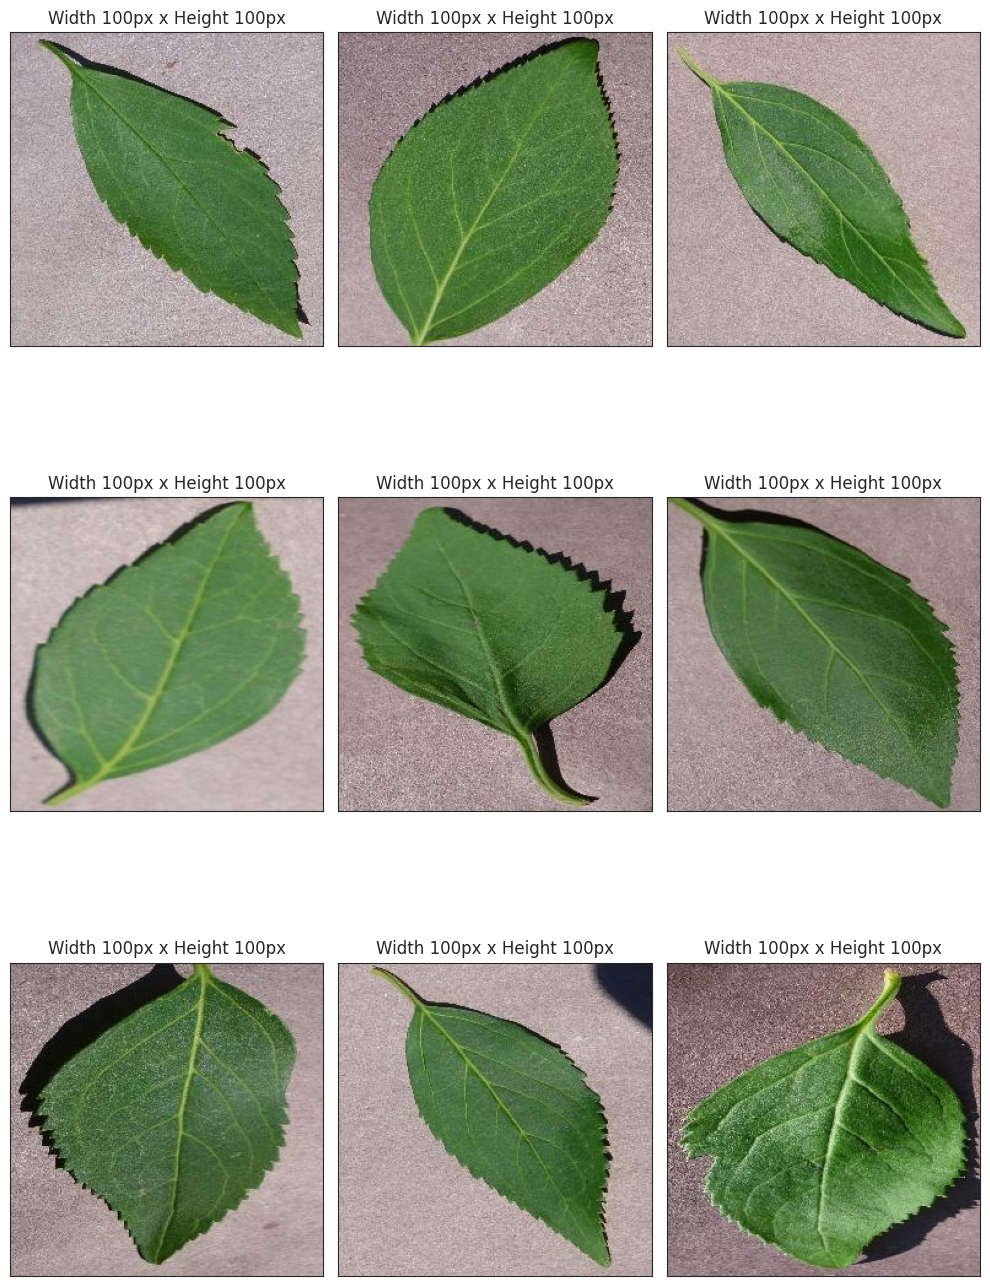



powdery_mildew


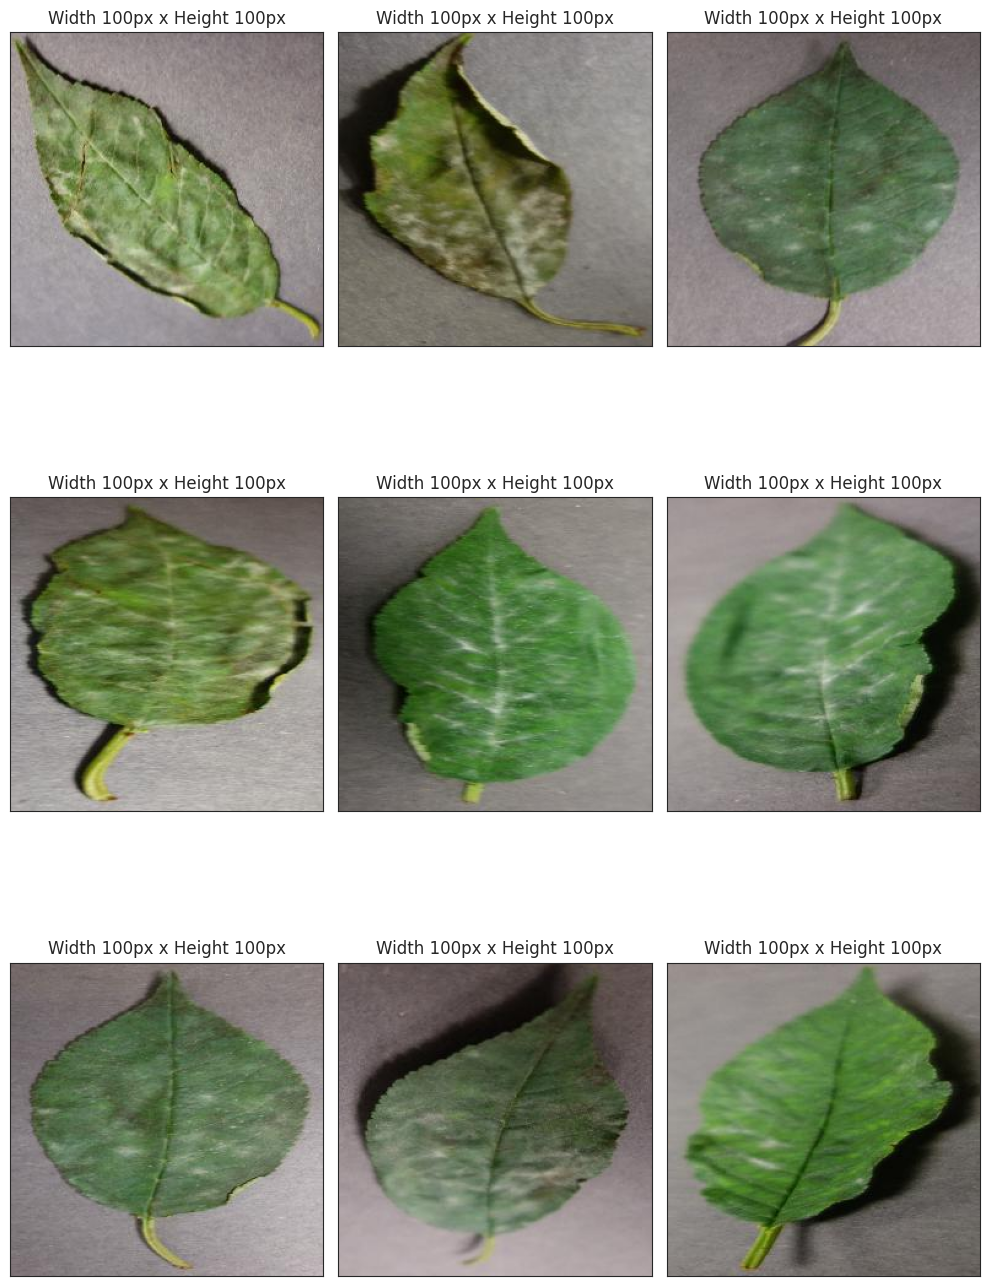

In [17]:
for label in labels:
    print(label)
    image_montage(dir_path=train_dir,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(10, 15),
                  image_shape = (100,100,3)
                  )
    print("\n")

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---